In [335]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from cst_modeling.section import cst_foil, cst_foil_fit, normalize_foil # CST Modeling package https://cst-modeling3d.readthedocs.io/en/latest/index.html

# Font 
from pathlib import Path
import matplotlib.font_manager as fm
import matplotlib

font_path = '/home/hlee981/Documents/Lift_Distribution/Onera_M6/2025 Scitech/Times New Roman.ttf'
fm.fontManager.addfont(font_path)
prop = fm.FontProperties(fname=font_path)
plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = "stix"

## Demonstrating how to use the functions

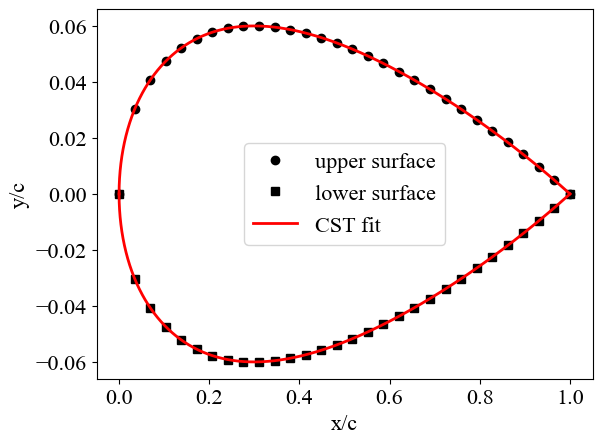

In [336]:
def gen_naca4digit_sym(num_pts, thickness):
    t = thickness/100
    xu, xl = np.linspace(0.0, 1.0, num_pts), np.linspace(0.0, 1.0, num_pts)
    y = lambda x: 5*t * (0.2969*np.sqrt(x) - 0.1260*x - 0.3516*x**2 + 0.2843*x**3 - 0.1036*x**4)
    yu, yl = y(xu), -y(xl)
    return (xu, xl), (yu, yl)

(naca0012_xu, naca0012_xl), (naca0012_yu, naca0012_yl) = gen_naca4digit_sym(30, thickness = 12)

# Fit CST to airfoil coordinates
cst_u, cst_l = cst_foil_fit(naca0012_xu, naca0012_yu, naca0012_xl, naca0012_yl, n_cst=10)

# Inverse transform back to coordinates
i_x, i_yu, i_yl, _, _ = cst_foil(1001, cst_u, cst_l)

# Calculate error 
yu_pred = np.interp(naca0012_xu, i_x, i_yu)
yl_pred = np.interp(naca0012_xl, i_x, i_yl)
err = np.sqrt(np.mean((np.hstack((yu_pred, yl_pred)) - np.hstack((naca0012_yu, naca0012_yl)))**2))

# Plot result
plt.figure()
plt.plot(naca0012_xu, naca0012_yu, 'ko', label = 'upper surface')
plt.plot(naca0012_xl, naca0012_yl, 'ks', label = 'lower surface')
plt.plot(i_x, i_yu, linewidth = 2.0, color = 'r', label = 'CST fit')
plt.plot(i_x, i_yl, linewidth = 2.0, color = 'r')
plt.xlabel('x/c')
plt.ylabel('y/c')
plt.legend()

plt.show()


## Trend Study 

In [337]:
# Create list of coordinate files that are available
af_dir = '/home/hlee981/Documents/GP-Aero/Airfoil Database/Digitized data/'
af_unique = os.listdir(af_dir)
coord_list = []
af_list = []
for i in range(len(af_unique)):
    af_dir_full = af_dir + af_unique[i] + '/'
    dir_list = os.listdir(af_dir_full)
    coord_file = [file for file in dir_list if file.endswith('coordinates.csv')]
    if len(coord_file) > 0:
        coord_list.append(af_dir_full + coord_file[0])
        af_list.append(af_unique[i])
        
exclude_inds = [5, 10] 
for index in sorted(exclude_inds, reverse=True):
    del coord_list[index] 
    del af_list[index] 

Compare results 

KeyboardInterrupt: 

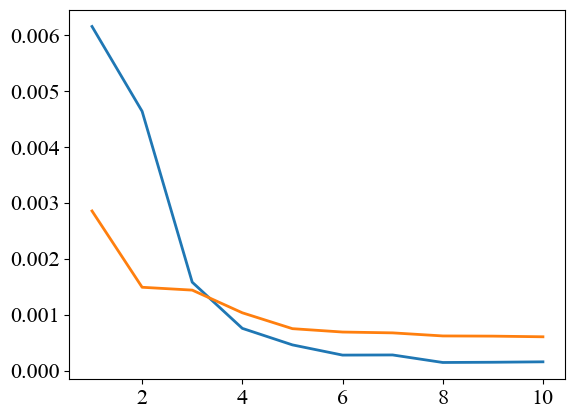

In [338]:
test_cases = [0, 1, 2, 3]

n_max = 10
for j in range(0, len(test_cases)): # len(coord_list)
    err_list = []
    for k in range(1, n_max+1):
        # Read in csv
        csv_data = pd.read_csv(coord_list[test_cases[j]], header=None).values
        x_all, y_all = csv_data[:,0], csv_data[:,1]

        x_all -= np.min(x_all)
        y_all -= np.min(np.abs(y_all))

        sign_change = np.argwhere(np.diff(np.sign(np.diff(x_all)))>0)
        cutoff_ind = sign_change[0][0] + 2 
        
        # asdf = np.argwhere(np.diff(np.sign(np.diff(x_all)))>0)[0][0]
        if len(sign_change) == 2: # Same LE point defined
            cutoff_ind = sign_change[0][0] + 2 
            xu, xl = np.flip(x_all[:cutoff_ind]), x_all[cutoff_ind:]
            yu, yl = np.flip(y_all[:cutoff_ind]), y_all[cutoff_ind:]
            
            xx = np.linspace(0.0, 1.0, 600)
            yuu = np.interp(xx, xu, yu)
            yll = np.interp(xx, xl, yl)
        elif len(sign_change) == 1: # 1 LE point, use same 
            cutoff_ind = sign_change[0][0] + 2 
            xu, xl = np.flip(x_all[:cutoff_ind]), x_all[cutoff_ind-1:]
            yu, yl = np.flip(y_all[:cutoff_ind]), y_all[cutoff_ind-1:]
            
            xx = np.linspace(0.0, 1.0, 600)
            yuu = np.interp(xx, xu, yu)
            yll = np.interp(xx, xl, yl)
            
        # Convert to CST
        # cst_u, cst_l = cst_foil_fit(xu, yu, xl, yl, n_cst=k)
        cst_u, cst_l = cst_foil_fit(xx, yuu, xx, yll, n_cst=k)

        # Inverse transform back to coordinates
        i_x, i_yu, i_yl, _, _ = cst_foil(1001, cst_u, cst_l, tail = np.abs(yuu[-1]-yll[-1]))

        # Calculate error 
        yu_pred = np.interp(xu, i_x, i_yu)
        yl_pred = np.interp(xl, i_x, i_yl)
        
        
        
        err = np.sqrt(np.mean((np.hstack((yu_pred, yl_pred)) - np.hstack((yu, yl)))**2))
        err_list.append(err)
    plt.plot(range(1, n_max+1), err_list , label = af_list[test_cases[j]], linewidth=2.0)

plt.xlabel('Number of CST terms per side')
plt.ylabel('RMSE')
plt.legend()
plt.show()

## View all separately

<Figure size 640x480 with 0 Axes>

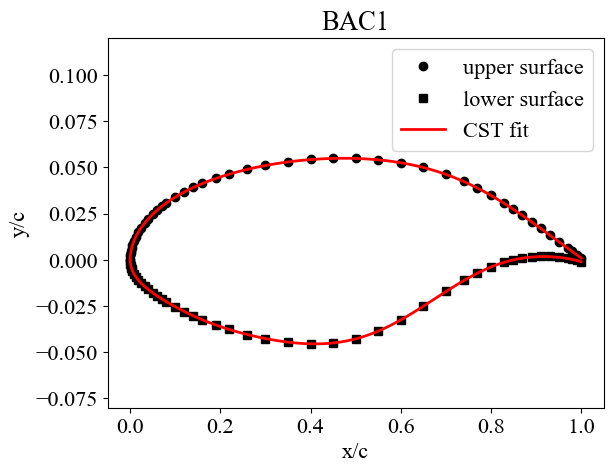

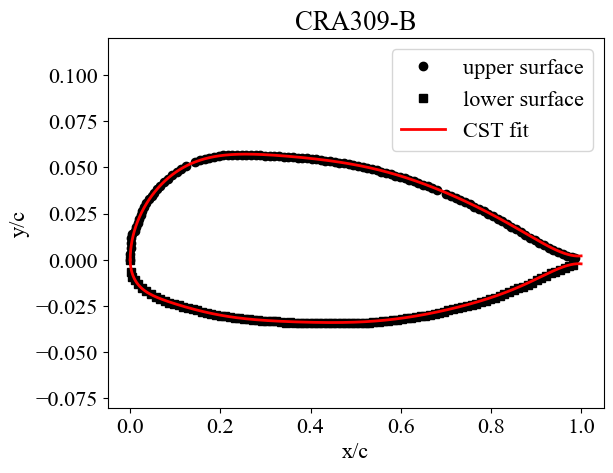

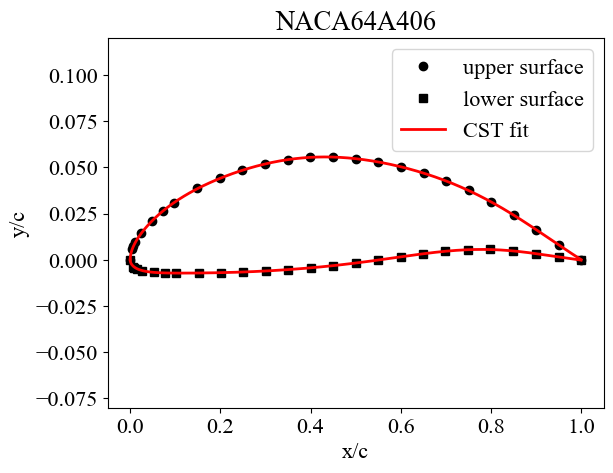

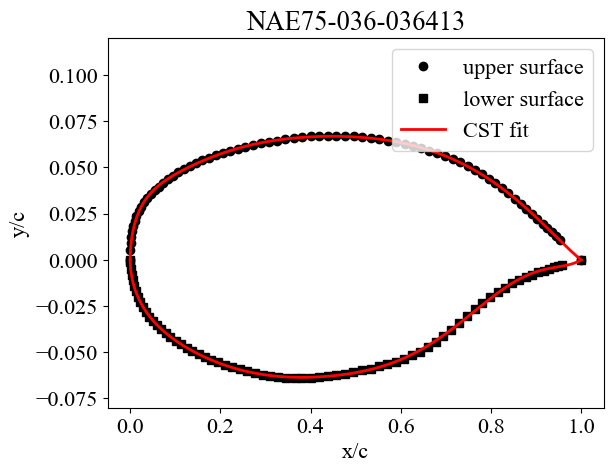

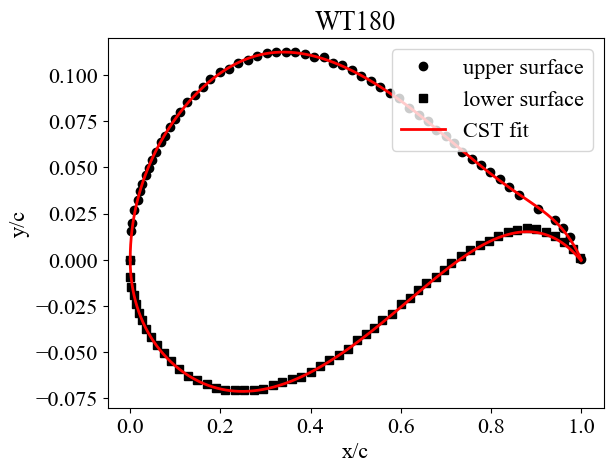

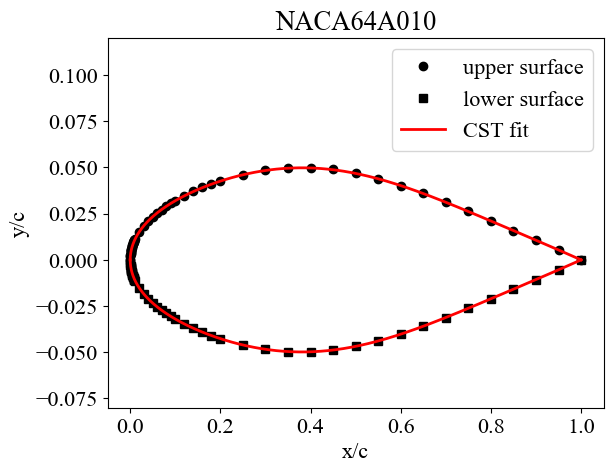

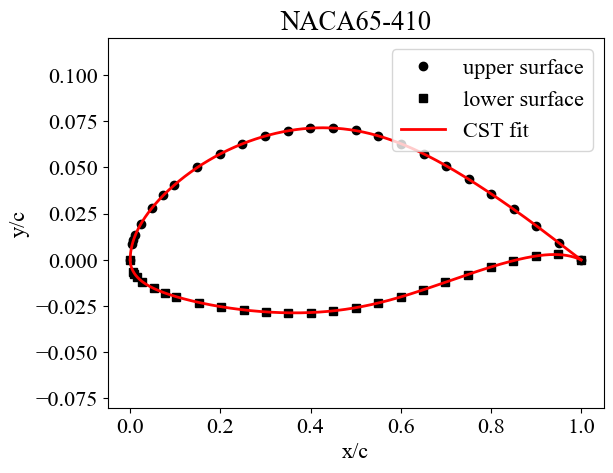

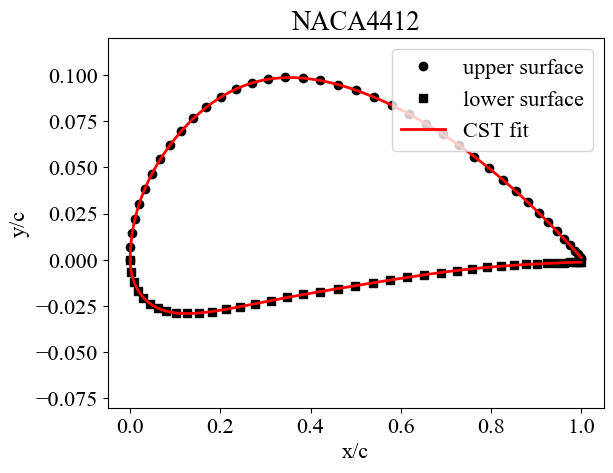

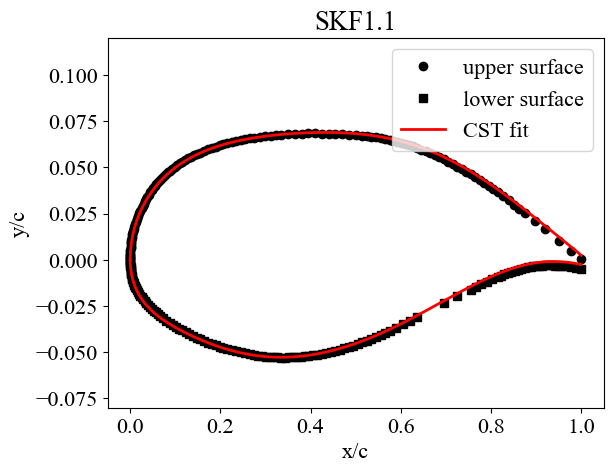

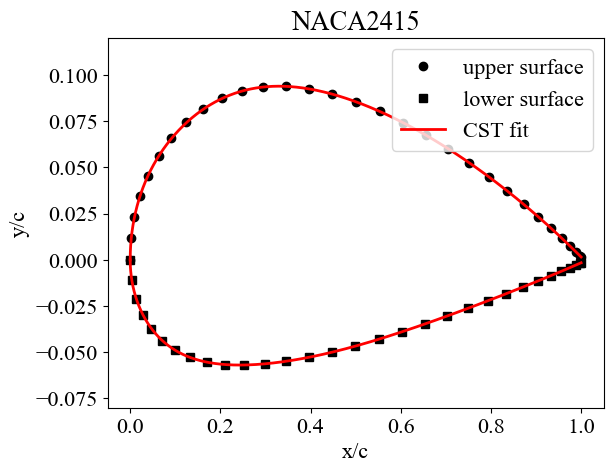

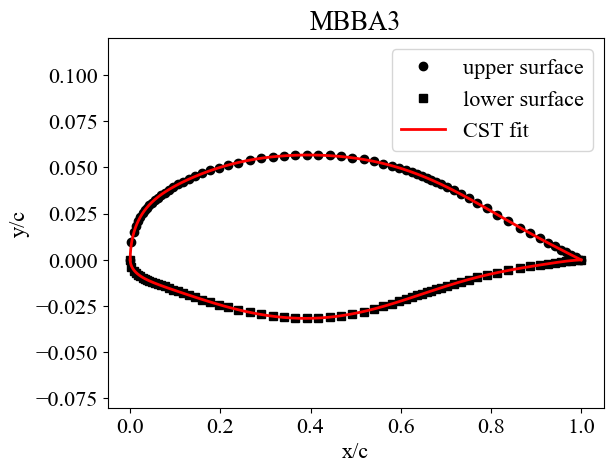

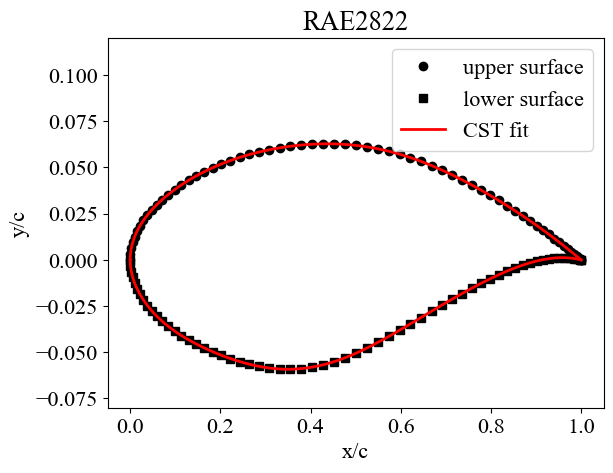

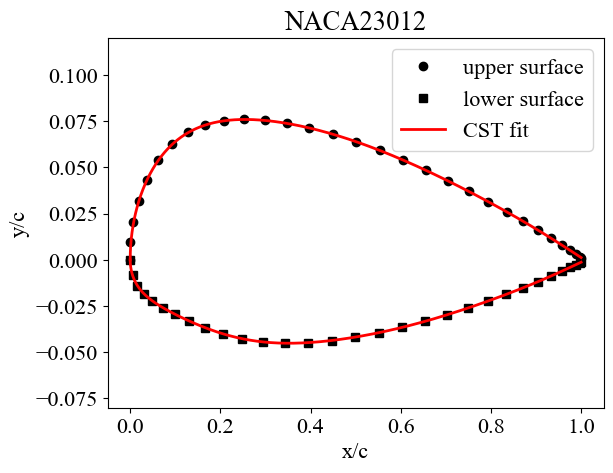

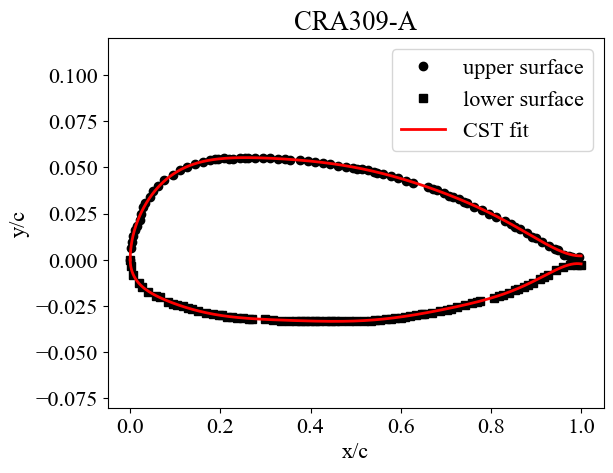

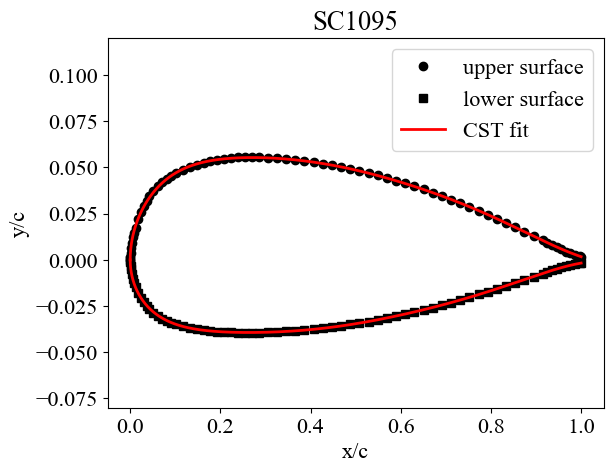

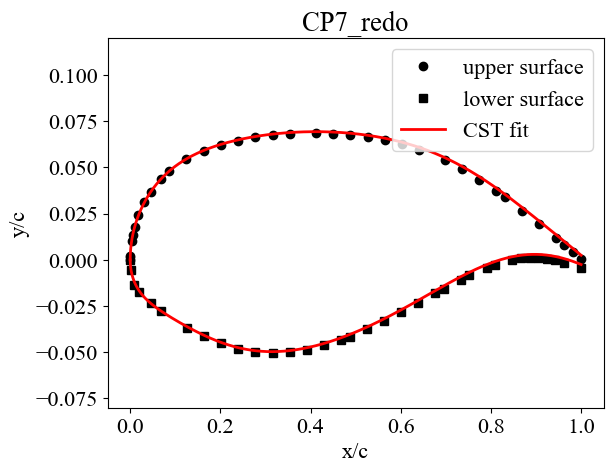

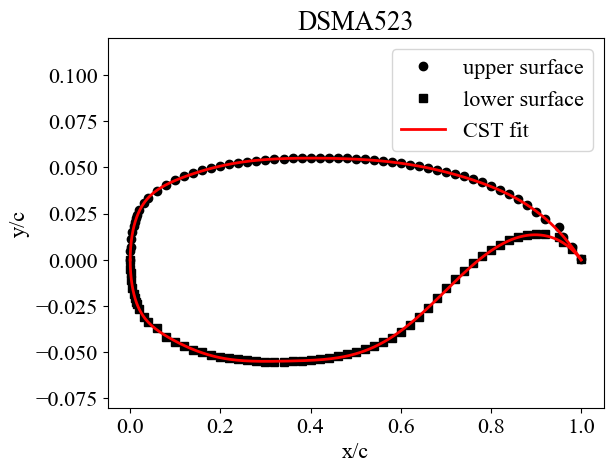

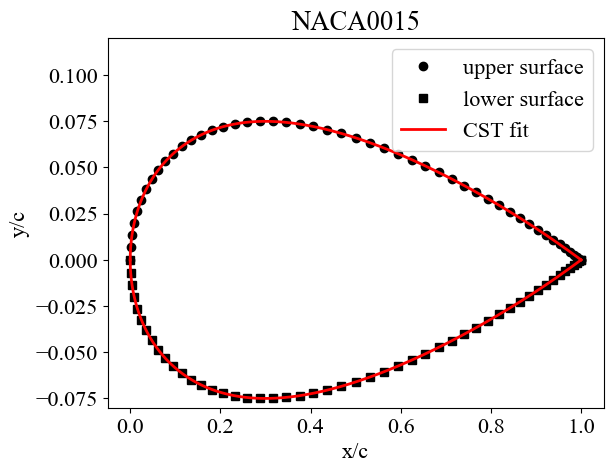

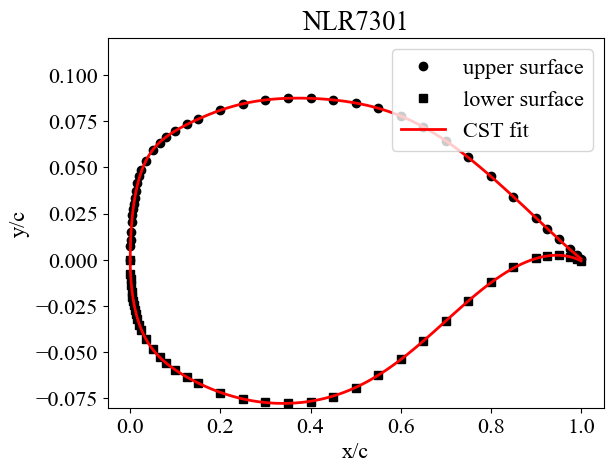

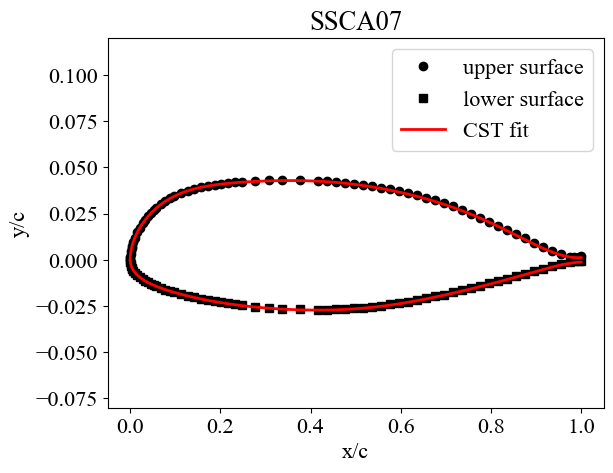

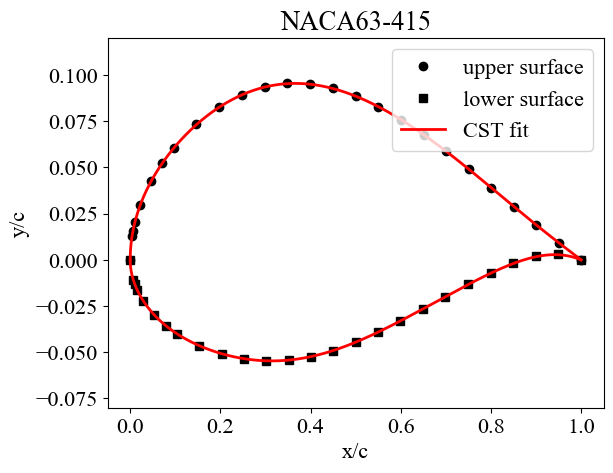

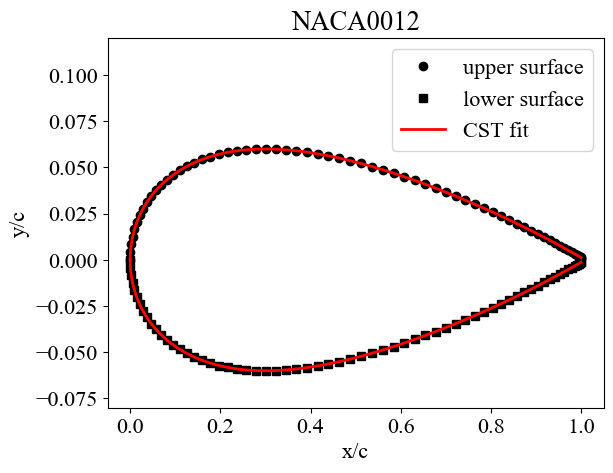

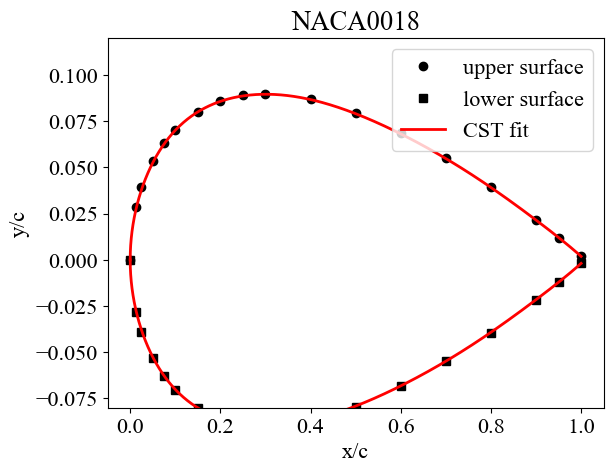

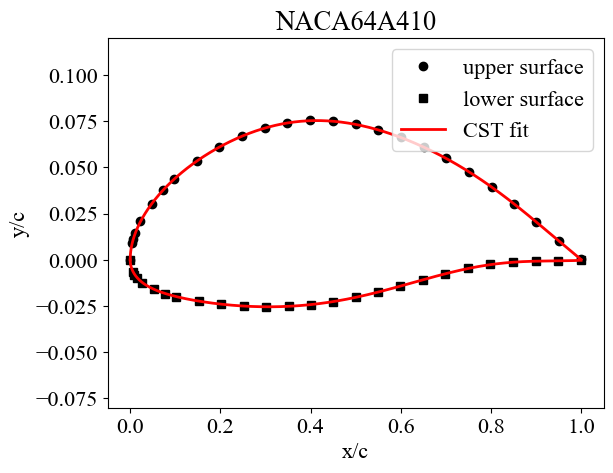

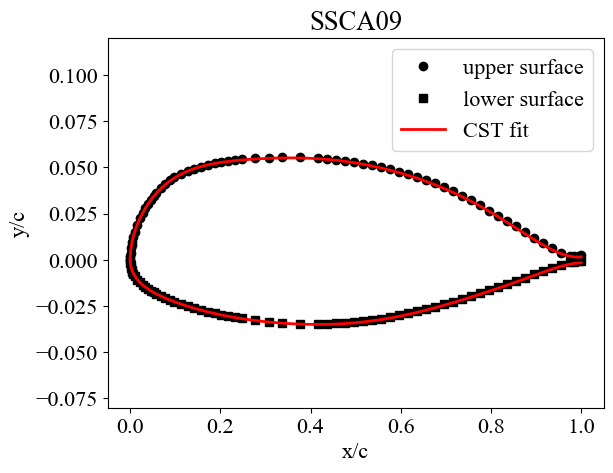

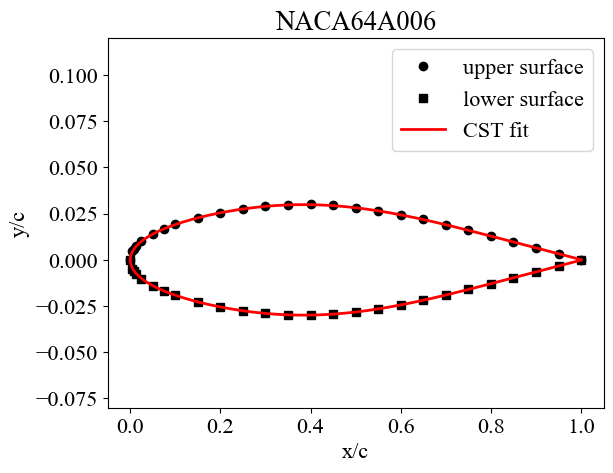

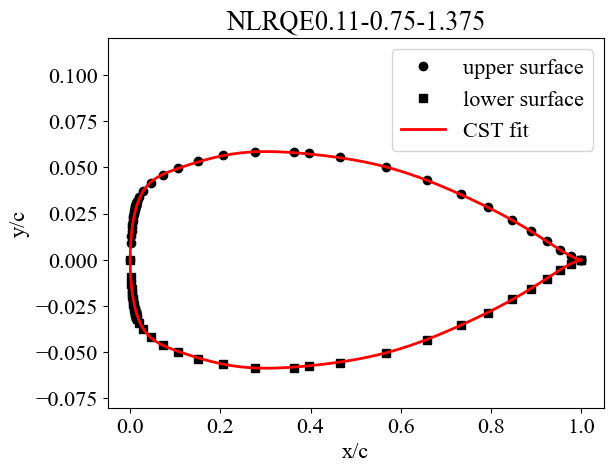

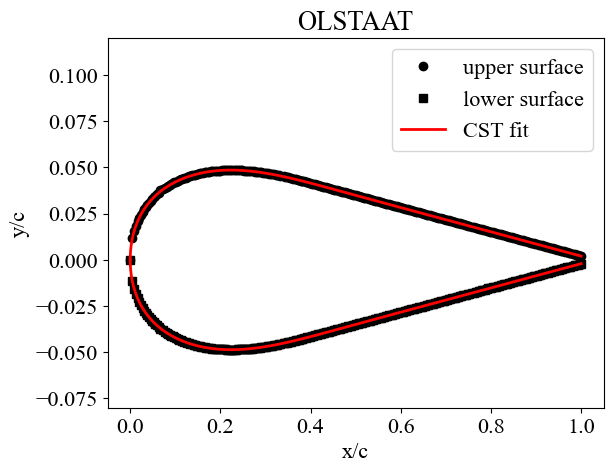

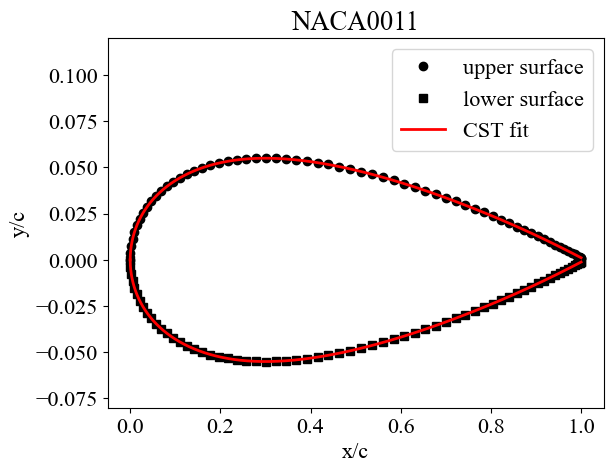

In [343]:
plt.figure()
n_max = 8
cstu_list = []
cstl_list = []
tail_list = []
for j in range(0, len(coord_list)): # len(coord_list)
    err_list = []
    for k in range(8, n_max+1):
        # Read in csv
        csv_data = pd.read_csv(coord_list[j], header=None).values
        x_all, y_all = csv_data[:,0], csv_data[:,1]

        x_all -= np.min(x_all)
        y_all -= np.min(np.abs(y_all))

        sign_change = np.argwhere(np.diff(np.sign(np.diff(x_all)))>0)
        cutoff_ind = sign_change[0][0] + 2 
        
        # asdf = np.argwhere(np.diff(np.sign(np.diff(x_all)))>0)[0][0]
        if len(sign_change) == 2: # Same LE point defined
            cutoff_ind = sign_change[0][0] + 2 
            xu, xl = np.flip(x_all[:cutoff_ind]), x_all[cutoff_ind:]
            yu, yl = np.flip(y_all[:cutoff_ind]), y_all[cutoff_ind:]
            
            xx = np.linspace(0.0, 1.0, 600)
            yuu = np.interp(xx, xu, yu)
            yll = np.interp(xx, xl, yl)
        elif len(sign_change) == 1: # 1 LE point, use same 
            cutoff_ind = sign_change[0][0] + 2 
            xu, xl = np.flip(x_all[:cutoff_ind]), x_all[cutoff_ind-1:]
            yu, yl = np.flip(y_all[:cutoff_ind]), y_all[cutoff_ind-1:]
            
            xx = np.linspace(0.0, 1.0, 600)
            yuu = np.interp(xx, xu, yu)
            yll = np.interp(xx, xl, yl)
            
        # Convert to CST
        # cst_u, cst_l = cst_foil_fit(xu, yu, xl, yl, n_cst=k)
        cst_u, cst_l = cst_foil_fit(xx, yuu, xx, yll, n_cst=k)
        cstu_list.append(cst_u)
        cstl_list.append(cst_l)
        
        # Inverse transform back to coordinates
        i_x, i_yu, i_yl, _, _ = cst_foil(1001, cst_u, cst_l, tail = np.abs(yuu[-1]-yll[-1]))
        tail_list.append(np.abs(yuu[-1]-yll[-1]))
        
        # Calculate error 
        yu_pred = np.interp(xu, i_x, i_yu)
        yl_pred = np.interp(xl, i_x, i_yl)
        if k == n_max:
            # print(xu)
            # print(xl)
            plt.figure()
            plt.plot(xu, yu,'ko', label='upper surface')
            plt.plot(xl, yl,'ks', label='lower surface')
            plt.plot(i_x, i_yu, linewidth=2.0, color = 'r', label='CST fit')
            plt.plot(i_x, i_yl, linewidth=2.0, color = 'r')
            plt.title(af_list[j])
            plt.legend(loc='upper right')
            plt.xlabel('x/c')
            plt.ylabel('y/c')
            plt.ylim([-0.08, 0.12])
            plt.show()
        err = np.sqrt(np.mean((np.hstack((yu_pred, yl_pred)) - np.hstack((yu, yl)))**2))
        err_list.append(err)
    # plt.plot(err_list)    

In [354]:
import pickle 
save_dict = {'cst_upper': cstu_list,
             'cst_lower': cstl_list,
             'te_thickness': tail_list,
             }
with open('CST_geometry.pkl', "wb") as pickle_file:
    pickle.dump(save_dict, pickle_file)

(-0.1, 0.12)

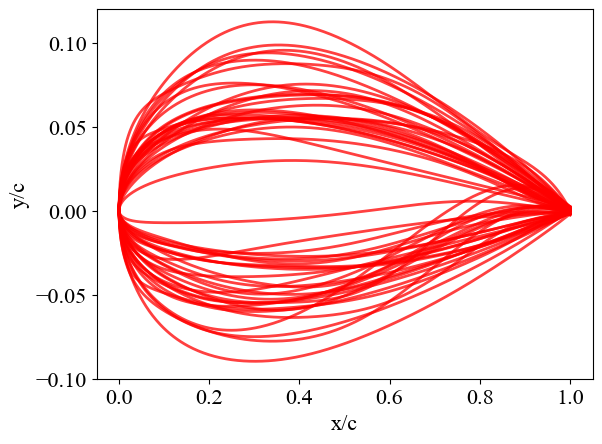

In [345]:
for i in range(0, len(af_list)):
    # inverse transform 
    i_x, i_yu, i_yl, _, _ = cst_foil(500, cstu_list[i], cstl_list[i], tail = tail_list[i])
    plt.plot(i_x, i_yu, 'r', alpha = 0.75, linewidth=2.0)
    plt.plot(i_x, i_yl, 'r', alpha = 0.75, linewidth=2.0)

plt.xlabel('x/c')
plt.ylabel('y/c')
plt.ylim([-0.10, 0.12])

## Visualize CST

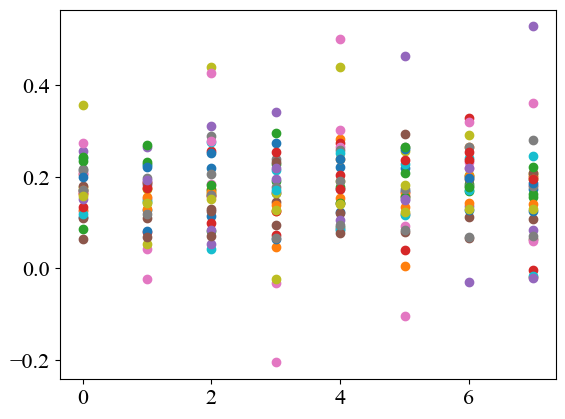

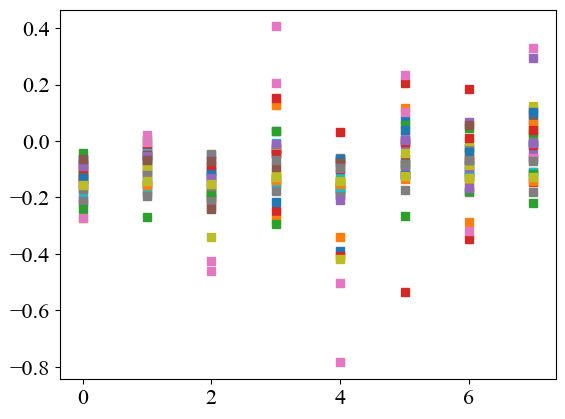

In [352]:
for i in range(0, len(cstu_list)):
    plt.plot(cstu_list[i],'o')
plt.show()

for i in range(0, len(cstu_list)):
    plt.plot(cstl_list[i],'s')
plt.show()